## Estimate melt fraction F, from trace element concenrations in n samples (assume F is the same for all samples).


Summary of estimated parameters
---------------------------------
Estimated melt fraction, F: 0.23 +/- 0.04

Observed C1: [ 1.   44.54  2.7   1.49] 
Predicted C1 [ 1.07 28.23  3.06  2.05]


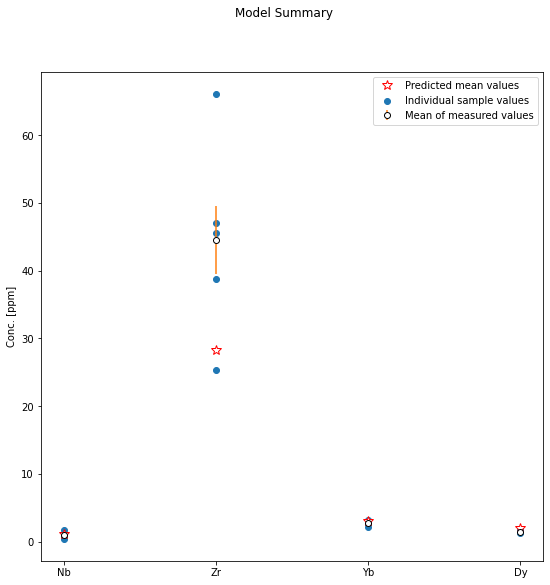

In [1]:
# -*- coding: utf-8 -*-

# Import required modules
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Set initial concentrations in mantle source, C0 values; Nb,Zr,Dy,Yb
C0 = np.array([0.2462,6.087,0.543,0.382]) #enriched MOR

# Measured concentrations of trace elements in samples; Nb,Zr,Dy,Yb

data = {
        'Nb':[0.77,0.86,1.16,1.74,0.45],
        'Zr':[38.8,45.5,47.0,66.1,25.3],
        'Yb':[2.70,2.72,2.75,3.16,2.19],
        'Dy':[1.53,1.45,1.48,1.71,1.26],
       }
traces = list(data.keys())
n = len(data['Nb'])
ntraces = ['Nb']*n+['Zr']*n+['Yb']*n+['Dy']*n
concentrations = np.array(list(data.values()))

#print(ntraces)
#print(concentrations.flatten())

trace_data = pd.DataFrame(data=data)

# Mean concentrations
C1 = np.array([1.00,44.54,2.70,1.49])
sc1 = np.array([0.25,5.0,0.5,0.3])  #Add arbitrary (made up) stddev of measured values

# Mineral proportions in mantle source and melt modes
mntl_modes = np.array([0.58,0.27,0.12,0.03])
melt_modes = np.array([0.2,0.25,0.45,0.1])

#Distribution coefficients for minerals; ol,opx,cpx,sp
Kd = {
      'Nb':[0.00005,0.0015,0.0081,0.08],
      'Zr':[0.00068,0.004,0.195,0.06],
      'Yb':[0.0055,0.015,0.711,0.008],
      'Dy':[0.0366,0.032,0.633,0.0076]   
     }

# Calculate bulk distribution coeeficients for melt (do this elegantly, i.e. properly with loop or something sensible :-)
P_Nb = sum(Kd['Nb']*melt_modes)
P_Zr = sum(Kd['Zr']*melt_modes)
P_Yb = sum(Kd['Yb']*melt_modes)
P_Dy = sum(Kd['Dy']*melt_modes)

# Calculate bulk distribution coeeficients for solid
D_Nb = sum(Kd['Nb']*mntl_modes)
D_Zr = sum(Kd['Zr']*mntl_modes)
D_Yb = sum(Kd['Yb']*mntl_modes)
D_Dy = sum(Kd['Dy']*mntl_modes)

# Store bulk distribution coefficients in numpy array for use
P = np.array([P_Nb,P_Zr,P_Yb,P_Dy])
D = np.array([D_Nb,D_Zr,D_Yb,D_Dy])

# Package 1D arrays of C0,P and D to pass into the function to solve
Variables = np.array([C0,P,D])

# Define function for use with curve_fit()
def meltfc(Variables,F):
    C0,P,D = Variables  #Unpack 1D arrays
    return (C0/(F*((1-P)+D)))

# Do curve fit stuff here with bounds
#-------------------------------------------------------------------
F0=0.5  #Initial guess for F

# Set min-max bounds on parameter search for F
param_bounds=([0.001],[1.])

# Run non-linear curve fit [popt is an array containing optimum fitted parameter values, pcov is the covariance matrix]
popt, pcov = curve_fit(meltfc, Variables, C1, sigma=sc1, p0=F0, bounds=param_bounds, method='dogbox')

perr = np.sqrt(np.diag(pcov))

# Write out results of interest...
print ('\nSummary of estimated parameters\n---------------------------------')
print (f'Estimated melt fraction, F: {popt[0]:.2f} +/- {perr[0]:.2f}')

np.set_printoptions(precision=2,suppress=True)
print(f'\nObserved C1: {C1} \nPredicted C1 {meltfc(Variables,*popt)}')


# Draw plot (basically a simple x,y graph, uses matplotlib routines from pyplot)
#--------------------------------------------------------
style_data = {'marker':'o','markersize':6, 'markerfacecolor':'w', 'markeredgecolor':'k',
       'elinewidth':1.5,'linewidth':0, 'label':'Mean of measured values'}

fig, axs = plt.subplots(1, 1, figsize=(9, 9), sharey=True)

axs.set_ylabel('Conc. [ppm]')

# Model predictions
axs.plot(traces, meltfc(Variables,*popt),'*', markersize=10, markerfacecolor='w',
            markeredgecolor='r', label='Predicted mean values')
# Observed mean values
axs.errorbar(traces, C1, yerr=sc1, **style_data)

# Observed individual sample values
axs.scatter(ntraces,concentrations.flatten(), label='Individual sample values')

axs.legend()

fig.suptitle('Model Summary')

plt.show()
